### Jump down to task 1 to get to the actual part, till then I'm just loading the dataset, the architecture, the inception model for FID, and a classifier

In [1]:
import os
import sys
import time
import random

import numpy as np
import pandas as pd
from scipy import linalg
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.nn.functional import adaptive_avg_pool2d

import torchvision
from torchvision import datasets, transforms, models, utils
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# loading dataset

100%|██████████| 170M/170M [00:12<00:00, 14.1MB/s] 


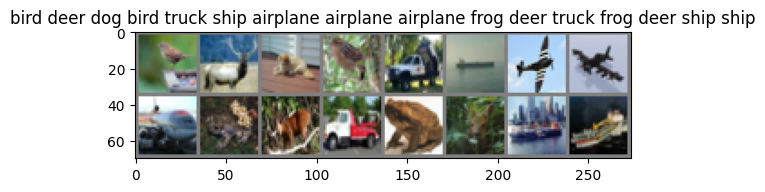

In [2]:
trainset = torchvision.datasets.CIFAR10(root='/kaggle/working', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='/kaggle/working', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

images, labels = next(iter(testloader))
images, labels = images[:16], labels[:16]
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5); 
plt.title(' '.join(trainset.classes[label] for label in labels)); plt.show()

# Loading inception model for FID

In [3]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 205MB/s] 


# Getting classifier + helper funcs

In [4]:
cifar10_classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# ================================
# Normalization
# ================================
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])


# ================================
# Load pretrained classifier
# ================================
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", 
                            "cifar10_resnet56", pretrained=True)

classifier = classifier.to(device).eval()

# ================================
# Helper functions
# ================================
# 1. Predict single image
def predict_image(img):
    """
    img: torch.Tensor shape [3,H,W] in range [-1,1]
    returns: class name (str)
    """
    # Normalize for CIFAR-10 pretrained model
    img = (img + 1) / 2
    transform = transforms.Normalize(cifar10_mean, cifar10_std)
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = classifier(img)
        _, pred = outputs.max(1)
    return cifar10_classes[pred.item()]

# 2. Evaluate accuracy on loader
def evaluate_accuracy(loader):
    """
    loader: DataLoader with (images, labels)
    returns: accuracy in %
    """
    correct, total = 0, 0
    classifier.eval()
    with torch.no_grad():
        for images, labels in loader:
            # images are in [-1,1], map back to [0,1]
            imgs = (images + 1.0) / 2.0
            # Normalize for CIFAR-10 pretrained model
            transform = transforms.Normalize(cifar10_mean, cifar10_std)
            imgs = torch.stack([transform(img) for img in imgs]).to(device)
            labels = labels.to(device)
        
            outputs = classifier(imgs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

# 3. Class distribution counter
def class_distribution(images):
    """
    images: torch.Tensor [B,3,H,W] in range [-1,1]
    returns: dict {class_name: count}
    """
    # GAN images are in [-1,1], map back to [0,1]
    imgs = (images + 1.0) / 2.0
    # Normalize for CIFAR-10 pretrained model
    transform = transforms.Normalize(cifar10_mean, cifar10_std)
    imgs = torch.stack([transform(img) for img in imgs]).to(device)

    counts = {cls: 0 for cls in cifar10_classes}
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(imgs)
        preds = outputs.argmax(dim=1)
        for p in preds.cpu().numpy():
            counts[cifar10_classes[p]] += 1
    return counts

# Check accuracy on testset
acc = evaluate_accuracy(testloader)
print(f"Test accuracy: {acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt
100%|██████████| 3.39M/3.39M [00:00<00:00, 103MB/s]

Test accuracy: 94.37%


# Task 1: Training the model

## Architecture
- following the GAN, the VAE will also have latent_dims=256

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(1024*2*2, latent_dim)
        self.fc_logvar = nn.Linear(1024*2*2, latent_dim)

    def forward(self, x):
        h1 = F.relu(self.bn1(self.conv1(x)))
        h2 = F.relu(self.bn2(self.conv2(h1)))
        h3 = F.relu(self.bn3(self.conv3(h2)))
        h4 = F.relu(self.bn4(self.conv4(h3)))

        h_flat = self.flatten(h4)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar

class ResidualDecoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 1024*2*2)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(128, 3, 4, 2, 1)

        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, z):
        h = self.fc(z).view(-1, 1024, 2, 2)

        x1 = F.relu(self.bn1(self.deconv1(h)))
        x2 = F.relu(self.bn2(self.deconv2(x1)))
        x3 = F.relu(self.bn3(self.deconv3(x2)))
        x_hat = torch.tanh(self.deconv4(x3))
        return x_hat

class VAE(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = ResidualDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum") / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_loss, recon_loss, kl_loss

## Training

In [6]:
vae = VAE(latent_dim=256).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.999))

num_epochs = 50

logs = {
    "train_losses" : [],
    "val_losses" : [],
    "recon_losses" : [],
    "kl_losses" : [],  
    "fid_dist" : []
}

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    for x, _ in trainloader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss, _, _ = vae_loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(trainloader.dataset)

    # Validation
    if (epoch + 1) % 5 == 0:
        vae.eval()
        val_loss = 0
        fid_dist = 0
        recon_loss_epoch = 0
        kl_loss_epoch = 0
        count = 0
        with torch.no_grad():
            for x, _ in testloader:
                count += 1
                x = x.to(device)
                recon_x, mu, logvar = vae(x)
                loss, recon_loss, kl_loss = vae_loss_function(recon_x, x, mu, logvar)
                val_loss += loss.item()
                if count <= 3:
                    fid_dist += calculate_fretchet(x, recon_x, model)
                recon_loss_epoch += recon_loss.item()
                kl_loss_epoch += kl_loss.item()

        avg_val_loss = val_loss / len(testloader.dataset)
        avg_recon_loss = recon_loss_epoch / len(testloader)
        avg_kl_loss = kl_loss_epoch / len(testloader)
        avg_fid_dist = fid_dist / 3

        logs["train_losses"].append(avg_train_loss)
        logs["val_losses"].append(avg_val_loss)
        logs["recon_losses"].append(avg_recon_loss)
        logs["kl_losses"].append(avg_kl_loss)
        logs["fid_dist"].append(avg_fid_dist)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Recon Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f} | FID: {avg_fid_dist:.4f}")

Epoch [5/50] Train Loss: 1.6723 | Val Loss: 1.6518 | Recon Loss: 153.6915 | KL Loss: 55.3917 | FID: 10.8998
Epoch [10/50] Train Loss: 1.5660 | Val Loss: 1.5710 | Recon Loss: 140.3613 | KL Loss: 58.4989 | FID: 9.0647
Epoch [15/50] Train Loss: 1.5189 | Val Loss: 1.5232 | Recon Loss: 133.9121 | KL Loss: 58.9033 | FID: 8.5294
Epoch [20/50] Train Loss: 1.4942 | Val Loss: 1.5142 | Recon Loss: 131.7587 | KL Loss: 59.9077 | FID: 8.2761
Epoch [25/50] Train Loss: 1.4703 | Val Loss: 1.5006 | Recon Loss: 127.8568 | KL Loss: 62.0939 | FID: 7.8586
Epoch [30/50] Train Loss: 1.4570 | Val Loss: 1.4780 | Recon Loss: 125.1044 | KL Loss: 61.9855 | FID: 7.7768
Epoch [35/50] Train Loss: 1.4454 | Val Loss: 1.4715 | Recon Loss: 124.7825 | KL Loss: 61.4780 | FID: 7.7515
Epoch [40/50] Train Loss: 1.4326 | Val Loss: 1.4603 | Recon Loss: 122.5965 | KL Loss: 62.2576 | FID: 7.8017
Epoch [45/50] Train Loss: 1.4231 | Val Loss: 1.4618 | Recon Loss: 122.0174 | KL Loss: 63.0231 | FID: 7.5588
Epoch [50/50] Train Loss: 1.

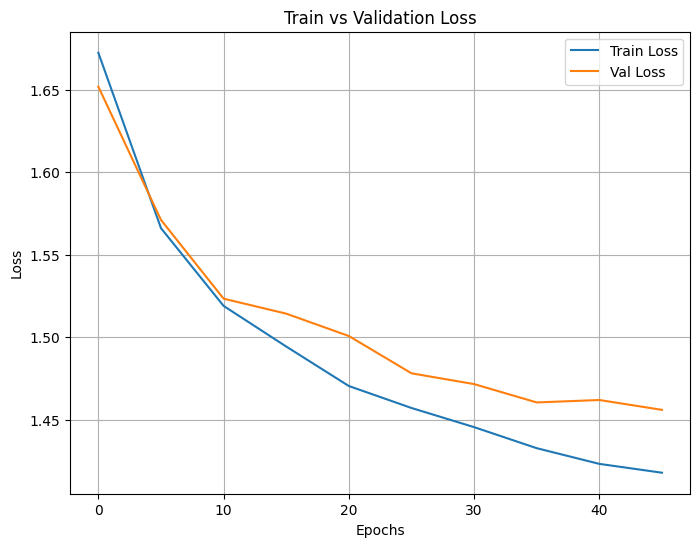

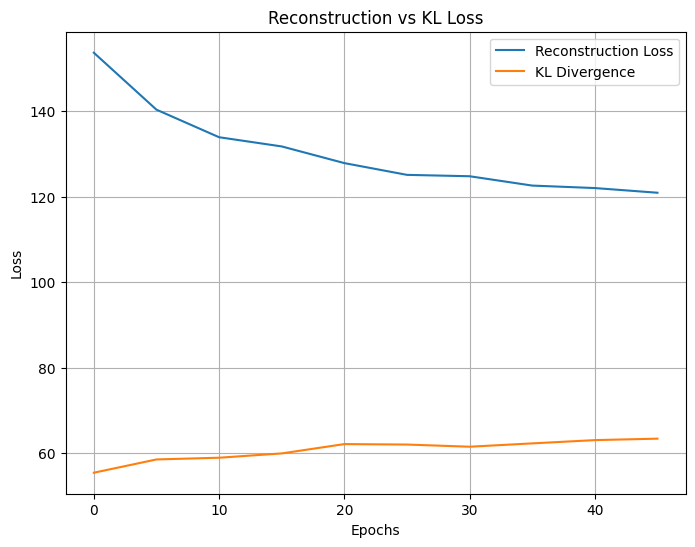

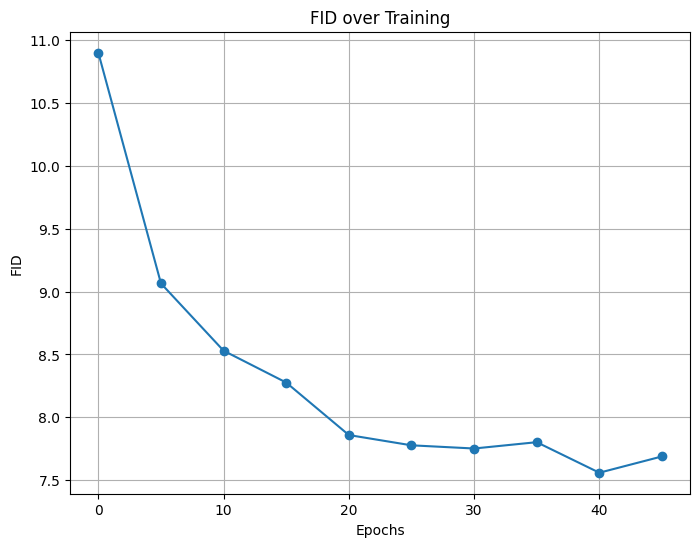

In [7]:
# --- 1. Train vs Val Loss ---
plt.figure(figsize=(8,6))
plt.plot(range(0, len(logs["train_losses"])*5, 5), logs["train_losses"], label="Train Loss")
plt.plot(range(0, len(logs["val_losses"])*5, 5), logs["val_losses"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Reconstruction vs KL Loss ---
plt.figure(figsize=(8,6))
plt.plot(range(0, len(logs["recon_losses"])*5, 5), logs["recon_losses"], label="Reconstruction Loss")
plt.plot(range(0, len(logs["kl_losses"])*5, 5), logs["kl_losses"], label="KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction vs KL Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. FID over training ---
plt.figure(figsize=(8,6))
plt.plot(range(0, len(logs["fid_dist"])*5, 5), logs["fid_dist"], marker='o')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID over Training")
plt.grid(True)
plt.show()

# Task 2: Analysing reconstructions
- Visual quality via inspection of reconstructions
- Diversity measure via classifier
- FID measure

### visual quality

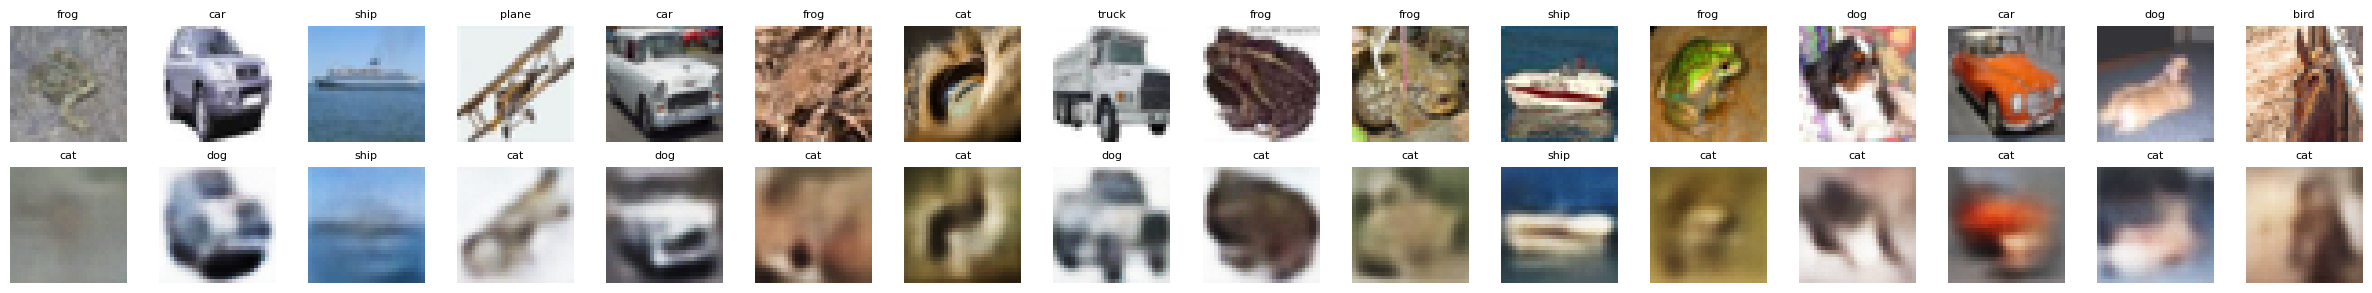

In [8]:
vae.eval()
# Sample a batch of test images
images, _ = next(iter(testloader))
images = images.to(device)[:16]  # take 16 for visualization

# Reconstruct
with torch.no_grad():
    recon_images, _, _ = vae(images)

# Get predicted labels
orig_labels = [predict_image(img) for img in images]
recon_labels = [predict_image(img) for img in recon_images]

# Plot original vs reconstruction with labels
fig, axes = plt.subplots(2, 16, figsize=(24,3))
for i in range(16):
    # Original
    axes[0,i].imshow((images[i].cpu().permute(1,2,0)+1)/2)
    axes[0,i].axis('off')
    axes[0,i].set_title(orig_labels[i], fontsize=8)
    
    # Reconstructed
    axes[1,i].imshow((recon_images[i].cpu().permute(1,2,0)+1)/2)
    axes[1,i].axis('off')
    axes[1,i].set_title(recon_labels[i], fontsize=8)

axes[0,0].set_ylabel("Original", fontsize=12)
axes[1,0].set_ylabel("Reconstruction", fontsize=12)
plt.tight_layout()
plt.show()

### diversity measure

In [9]:
vae.eval()
num_samples = 1000
collected_images = []
count = 0

for imgs, _ in testloader:
    imgs = imgs.to(device)
    collected_images.append(imgs)
    count += imgs.size(0)
    if count >= num_samples:
        break

# Concatenate and slice to exactly num_samples
images = torch.cat(collected_images, dim=0)[:num_samples]

# Reconstruct
with torch.no_grad():
    recon_images, _, _ = vae(images)

# Class distribution
distribution = class_distribution(recon_images)
print(f"Class distribution of {num_samples} reconstructions:")
for cls, count in distribution.items():
    print(f"{cls}: {count}")

Class distribution of 1000 reconstructions:
plane: 67
car: 2
bird: 142
cat: 556
deer: 25
dog: 93
frog: 14
horse: 5
ship: 96
truck: 0


### fid distance

In [16]:
vae.eval()
# Limit to 250 images to avoid OOM
images_real = []
images_fake = []
count = 0
for imgs, _ in testloader:
    b = imgs.size(0)
    if count + b > 250:
        imgs = imgs[:250-count]
    images_real.append(imgs.to(device))
    with torch.no_grad():
        recon, _, _ = vae(imgs.to(device))
        images_fake.append(recon)
    count += imgs.size(0)
    if count >= 250:
        break

images_real = torch.cat(images_real, dim=0)
images_fake = torch.cat(images_fake, dim=0)

fid_score = calculate_fretchet(images_real, images_fake, model)
print("FID (on 250 images):", fid_score)

FID (on 250 images): 175.1017549116973


# Task 3: Latent Space Exploration

### Interpolation

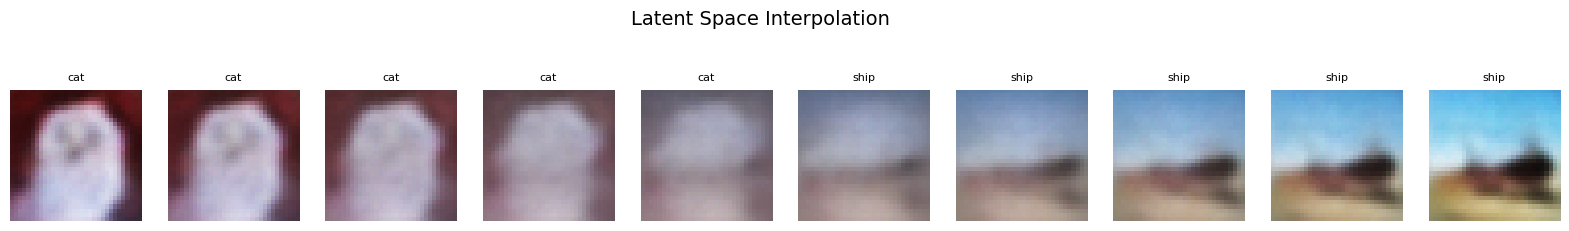

In [21]:
vae.eval()

# --- 1. Sample two random images from testloader ---
images_batch, _ = next(iter(testloader))
images_batch = images_batch.to(device)
idx = torch.randperm(images_batch.size(0))[:2]
img1, img2 = images_batch[idx[0]], images_batch[idx[1]]

# --- 2. Encode to latent vectors ---
with torch.no_grad():
    mu1, logvar1 = vae.encoder(img1.unsqueeze(0))
    mu2, logvar2 = vae.encoder(img2.unsqueeze(0))
    z1 = vae.reparameterize(mu1, logvar1)
    z2 = vae.reparameterize(mu2, logvar2)

# --- 3. Linear interpolation in latent space ---
num_steps = 10
interpolated_images = []
predicted_labels = []

with torch.no_grad():
    for alpha in torch.linspace(0, 1, steps=num_steps):
        z = (1 - alpha) * z1 + alpha * z2
        x_hat = vae.decoder(z)
        interpolated_images.append(x_hat.squeeze(0).cpu())
        predicted_labels.append(predict_image(x_hat.squeeze(0)))

# --- 4. Plot interpolated images with predicted labels ---
fig, axes = plt.subplots(1, num_steps, figsize=(20, 3))
for i in range(num_steps):
    axes[i].imshow((interpolated_images[i].permute(1,2,0)+1)/2)  # rescale [-1,1] -> [0,1]
    axes[i].axis('off')
    axes[i].set_title(predicted_labels[i], fontsize=8)
plt.suptitle("Latent Space Interpolation", fontsize=14)
plt.show()


### PCA + TSNE

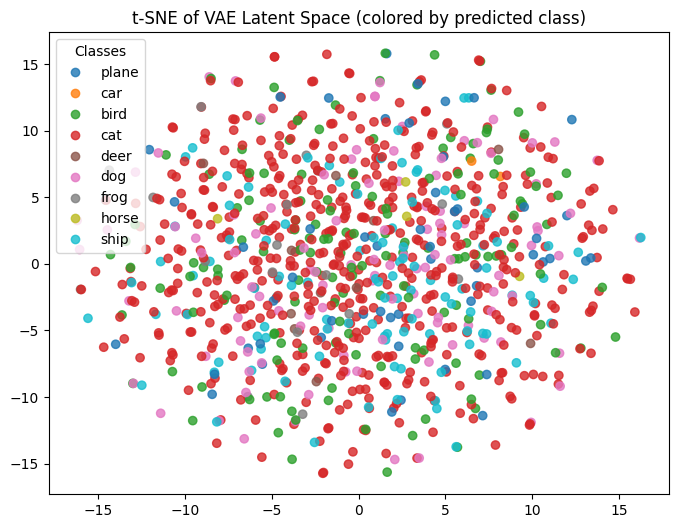

In [12]:
vae.eval()
num_samples = 1000
collected_images = []
count = 0

# 1. Collect 1000 test images
for imgs, _ in testloader:
    imgs = imgs.to(device)
    collected_images.append(imgs)
    count += imgs.size(0)
    if count >= num_samples:
        break

images = torch.cat(collected_images, dim=0)[:num_samples]

# 2. Encode images to latent vectors
with torch.no_grad():
    mu, logvar = vae.encoder(images)
    z = vae.reparameterize(mu, logvar).cpu().numpy()  # [num_samples, latent_dim]

# 3. Generate predicted labels from reconstructions
with torch.no_grad():
    recon_images = vae.decoder(torch.tensor(z, device=device)).cpu()

labels = [predict_image(img) for img in recon_images]

# 4. Map class names to integers for plotting
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
label_indices = np.array([class_names.index(l) for l in labels])

# 5. PCA + t-SNE
z_pca = PCA(n_components=50).fit_transform(z)
z_2d = TSNE(n_components=2, random_state=42).fit_transform(z_pca)

# 6. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=label_indices, cmap='tab10', alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes")
plt.title("t-SNE of VAE Latent Space (colored by predicted class)")
plt.show()

# Task 4: Out of order distribution

100%|██████████| 64.3M/64.3M [00:13<00:00, 4.90MB/s]


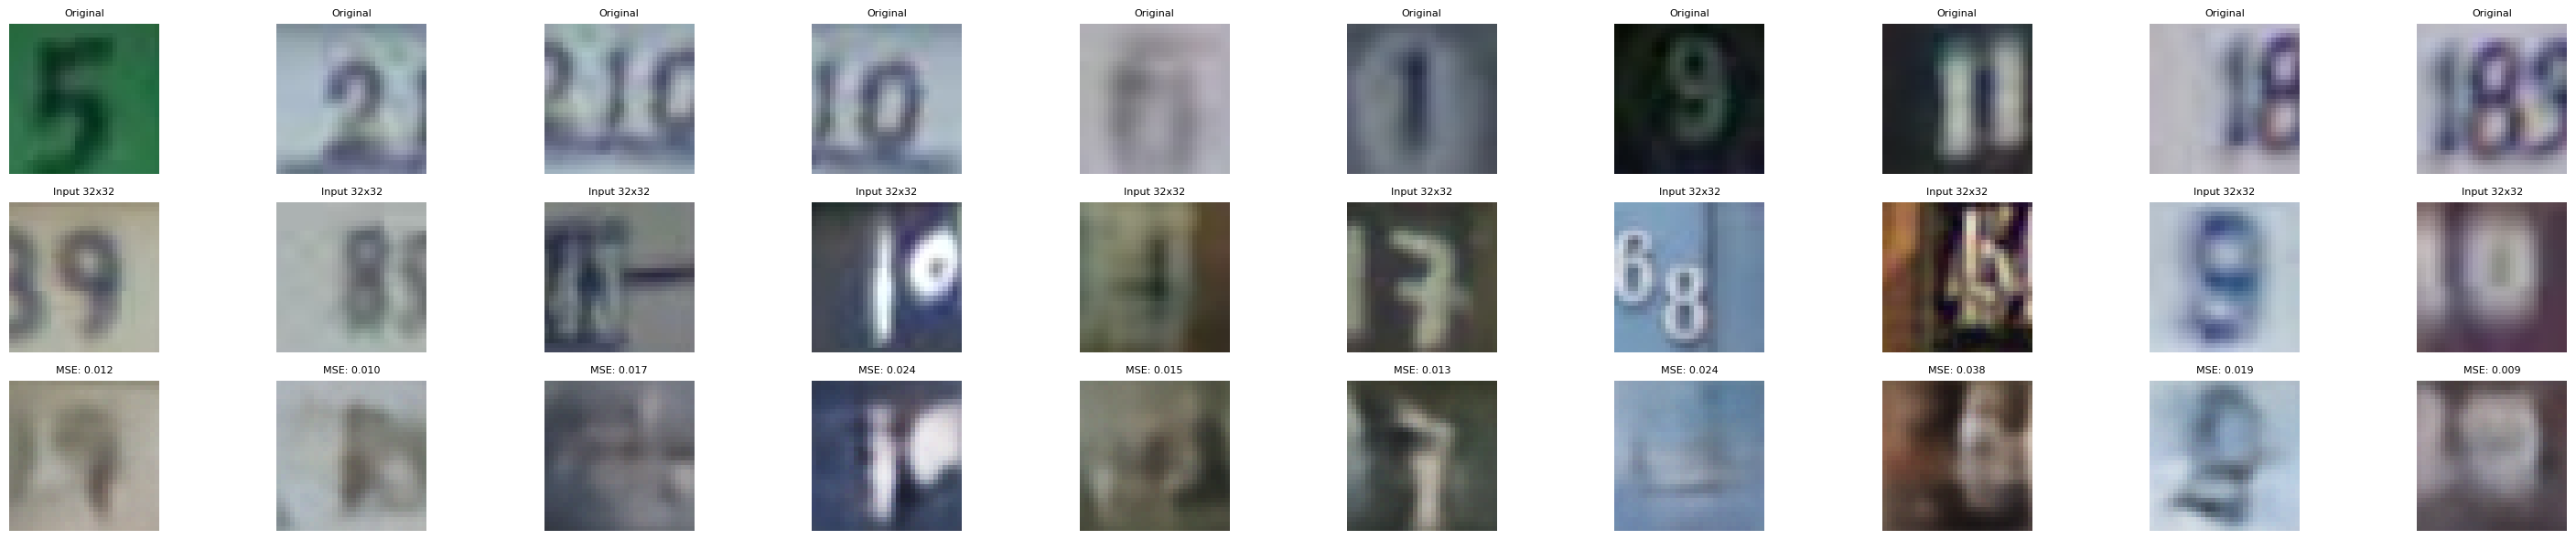

In [13]:
vae.eval()
device = next(vae.parameters()).device

num_samples = 10

# --- 1. Load SVHN test set ---
# SVHN images are 32x32 by default, but we store a copy before normalization for plotting
transform_resize = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

transform_vae = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

svhn_dataset = datasets.SVHN(root='./data', split='test', transform=transform_vae, download=True)
svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=num_samples, shuffle=True)

# --- 2. Sample 10 images ---
for imgs_raw, _ in svhn_loader:
    break  # take first batch
imgs_raw = imgs_raw.to(device)[:num_samples]  # normalized and resized for VAE

# Also get unnormalized images for original visualization
imgs_original = torch.stack([transform_resize(datasets.SVHN(root='./data', split='test', download=True)[i][0]) 
                             for i in range(num_samples)]).to(device)

# --- 3. VAE reconstruction ---
with torch.no_grad():
    recon_images, _, _ = vae(imgs_raw)

# --- 4. Compute reconstruction error ---
recon_errors = F.mse_loss(recon_images, imgs_raw, reduction='none')
recon_errors_per_image = recon_errors.view(recon_errors.size(0), -1).mean(dim=1).cpu().numpy()

# --- 5. Plot ---
fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 6))
for i in range(num_samples):
    # Original (before resizing)
    axes[0,i].imshow(imgs_original[i].cpu().permute(1,2,0))
    axes[0,i].axis('off')
    axes[0,i].set_title("Original", fontsize=8)
    
    # Resized & normalized input
    axes[1,i].imshow((imgs_raw[i].cpu().permute(1,2,0)+1)/2)
    axes[1,i].axis('off')
    axes[1,i].set_title("Input 32x32", fontsize=8)
    
    # Reconstructed
    axes[2,i].imshow((recon_images[i].cpu().permute(1,2,0)+1)/2)
    axes[2,i].axis('off')
    axes[2,i].set_title(f"MSE: {recon_errors_per_image[i]:.3f}", fontsize=8)

axes[0,0].set_ylabel("Original", fontsize=12)
axes[1,0].set_ylabel("Resized Input", fontsize=12)
axes[2,0].set_ylabel("VAE Recon", fontsize=12)
plt.tight_layout()
plt.show()